In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
pd.set_option('display.max_rows', 1000)
pd.options.display.float_format = "{:.3f}".format # Only display up to three decimal places

### Initial computations

In [2]:
elections = pd.read_csv('data/Elections/all_elections.csv', parse_dates = ['Date Filed', 'Date Closed'])
elections.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30907 entries, 0 to 30906
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Region                        30907 non-null  object        
 1   Case Number                   30907 non-null  object        
 2   Case Name                     30907 non-null  object        
 3   Status                        30907 non-null  object        
 4   Date Filed                    30907 non-null  datetime64[ns]
 5   Date Closed                   30498 non-null  datetime64[ns]
 6   Reason Closed                 30497 non-null  object        
 7   City                          30907 non-null  object        
 8   States & Territories          30907 non-null  object        
 9   Unit ID                       30907 non-null  object        
 10  Ballot Type                   30907 non-null  object        
 11  Tally Type                  

In [3]:
elections['Ballot Type'].value_counts()

Ballot Type
Single Labor Organization    28349
Two Labor Organizations       1553
Revised Single Labor Org       554
UD                             308
Three Labor Organizations      111
Revised Two Labor Orgs          32
Name: count, dtype: int64

In [4]:
# Restrict our attention to elections where only one union was on the ballot
single_elections = elections[elections['Ballot Type'] == 'Single Labor Organization']

In [5]:
# Restrict to representation elections
single_elections = single_elections[single_elections['Petition Type'] == 'RC']

In [6]:
# Set date closed as the index
single_elections.index = single_elections['Date Closed']

In [7]:
# Compute the percent yes vote in each election.
# Note that we could divide by the column 'Total Ballots Counted' but there are some cases where
# this seems to be erroneously equal to zero, e.g. 01-RC-270539. 
single_elections['Percent Votes Yes'] =  single_elections['Votes for Labor Union1'] / (single_elections[['Votes for Labor Union1', 'Votes Against', 'Challenged Ballots']].sum(axis = 1)) 
# Only display three decimal places
single_elections['Percent Votes Yes'] = single_elections['Percent Votes Yes'].round(3)

In [8]:
# Make it easier to read the win/loss outcome of the election
def get_outcome(row):
    if row['Percent Votes Yes'] > 0.5 or row['Reason Closed'] == "Certific. of Representative":
        return "Win"
    else:
        return "Loss"
single_elections['Outcome'] = single_elections.apply(get_outcome, axis = 1)

In [9]:
# Make a column that counts the number of new union members in successful union votes 
single_elections['Number Unionized'] = single_elections['No of Eligible Voters']*single_elections['Outcome'].apply(lambda x: 1 if x == "Win" else 0)

In [23]:
# Compute the duration of each case
single_elections['Duration'] = (single_elections['Date Closed']-single_elections['Date Filed']).apply(lambda x: x.days)

### General analysis

In [11]:
# Drop duplicate case numbers (some of these are re-runs of the same election)
single_elections = single_elections.drop_duplicates(subset=['Case Number'], keep = 'last')

In [12]:
# Resample to count the number of new union members per month
number_unionized_by_month = single_elections['Number Unionized'].resample("M").sum()
number_unionized_by_day = single_elections['Number Unionized'].resample("D").sum()

NameError: name 'rolling_average_number_by_month' is not defined

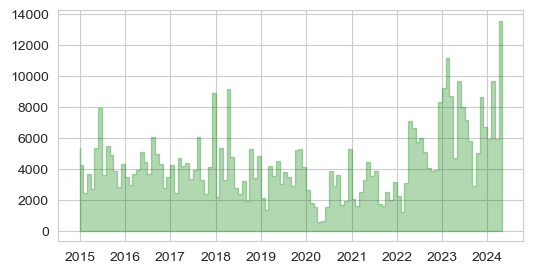

In [13]:
rolling_window = 182
rolling_average_number_by_day = number_unionized_by_day.loc["2014-07":"2024-04"].rolling(rolling_window).mean()
plt.figure(figsize = (6, 3))
plt.fill_between(number_unionized_by_month.loc["2014-12-31":"2024-04"].index, number_unionized_by_month.loc["2014-12-31":"2024-04"],  
                 color = 'green',
                 alpha = 0.3,
                 step='pre',
                label = f"Number of workers each month")
plt.plot(rolling_average_number_by_month.index, rolling_average_number_by_month, 
                 color = 'black',
                 linewidth = 4,
                label = f"Rolling 6-month average")
number_unionized_by_month.loc["2015":"2024-04"]
#plt.xlabel("Year")
plt.ylabel("New union members")
plt.ylim(bottom = 0)
plt.xlim(left = pd.to_datetime("2015-01-01"),right = pd.to_datetime("2024-06"))
plt.title(f"Newly unionized workers (private sector)")
plt.legend(loc = "upper left")
plt.savefig("new_union_members.png")
plt.show()

In [14]:
# Compute and display the five largest elections each year
# IMPORTANT: This data should include the ALU win in Staten Island (29-RC-288020)
# but it doesn't because this case is still listed as "open" in the NLRB database,
# due to Amazon contesting it.
five_biggest_by_year = single_elections.drop_duplicates(subset = 'Case Number').sort_values(by = "No of Eligible Voters",ascending = False)
five_biggest_by_year = five_biggest_by_year.groupby(by = five_biggest_by_year['Date Closed'].dt.year).head(5)
five_biggest_by_year['Year'] = five_biggest_by_year['Date Closed'].dt.year
five_biggest_by_year = five_biggest_by_year.sort_values(by = ['Year','No of Eligible Voters'], ascending = False)
filt = five_biggest_by_year['Year'] >= 2010
five_biggest_by_year = five_biggest_by_year[filt][['Year', 'Case Number', 'City', 'States & Territories', 'Union', 'No of Eligible Voters', 'Turnout', 'Percent Votes Yes', 'Outcome', 'Case Name']]
five_biggest_by_year['City']  = (five_biggest_by_year['City'] + ", " + five_biggest_by_year['States & Territories'])
five_biggest_by_year.drop(columns = ['States & Territories'], inplace = True)
five_biggest_by_year["No of Eligible Voters"] = five_biggest_by_year["No of Eligible Voters"].astype(int)
five_biggest_by_year = five_biggest_by_year.reset_index()
# Set styling to highlight alternating years and left-align the text and column headers
five_biggest_by_year = five_biggest_by_year.style.apply(lambda x: len(five_biggest_by_year.columns)*['background-color:#DDDDDD' if x['Year']%2 == 0 else 'background-color:white'], axis = 1)
five_biggest_by_year = five_biggest_by_year.hide(["Date Closed"], axis = 1).hide(axis = 'index')
five_biggest_by_year = five_biggest_by_year.set_properties(**{'text-align': 'left'})
five_biggest_by_year = five_biggest_by_year.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
five_biggest_by_year.format(precision=3)

Year,Case Number,City,Union,No of Eligible Voters,Turnout,Percent Votes Yes,Outcome,Case Name
2024,10-RC-338023,"Chattanooga, TN",UAW,4326,0.835,0.726,Win,"Volkswagen Group Of America, Inc."
2024,01-RC-336990,"Cambridge, MA",UAW,4172,0.282,0.871,Win,President And Fellows Of Harvard College
2024,04-RC-327396,"Philadelphia, PA",UAW,4003,0.476,0.779,Win,Trustees Of The University Of Pennsylvania
2024,12-RC-329128,"San Juan, PR",SEIU,1781,0.502,0.678,Win,"Xpert'S, Llc"
2024,21-RC-340226,"Anaheim, CA",OTHER,1713,0.707,0.786,Win,"Walt Disney Parks & Resorts, U.S., Inc."
2023,32-RC-316964,"Stanford, CA",UE,3410,0.512,0.938,Win,The Board Of Trustees Of The Leland Stanford Junior University
2023,01-RC-305762,"New Haven, CT",UNITE HERE,3214,0.634,0.851,Win,Yale University
2023,13-RC-307974,"Chicago, IL",UE,3200,0.608,0.872,Win,University Of Chicago
2023,05-RC-309139,"Baltimore, MD",UE,3186,0.665,0.968,Win,Johns Hopkins University
2023,03-RC-326874,"Ithaca, NY",UE,3175,0.655,0.900,Win,Cornell University


In [15]:
filt =  (single_elections['Duration'] >= 0) & (single_elections['Date Filed'] >= "2010")
durations = single_elections[filt]['Duration']
durations.index = single_elections[filt]['Date Filed']

In [16]:
# About 95% of cases are less than 200 days duration, so restrict our attention to those
print( (durations <= 200).sum()/(durations >= 0).sum() )
durations = durations[durations <= 200]

0.9472876712328767


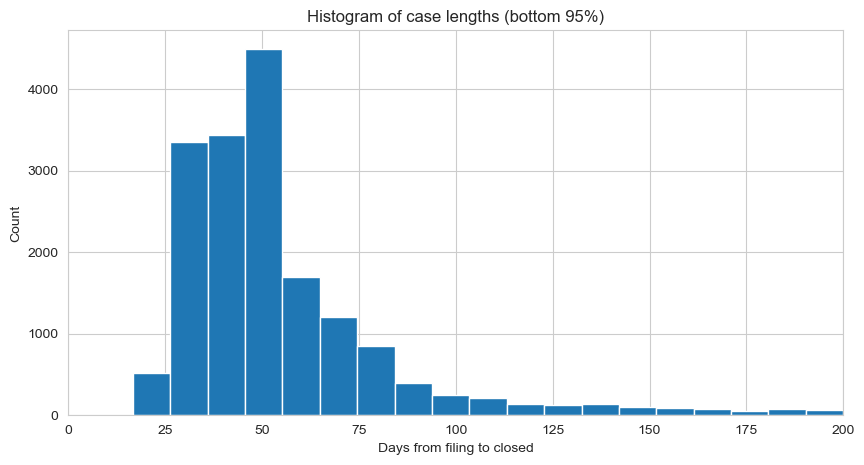

In [17]:
plt.figure(figsize = (10,5))
plt.hist(durations, bins = 20)
plt.xlim(left = 0, right = 200)
plt.ylabel("Count")
plt.xlabel("Days from filing to closed")
plt.title("Histogram of case lengths (bottom 95%)")
plt.show()


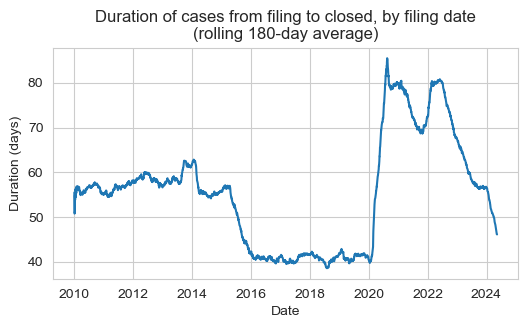

In [18]:
# Get rolling average of case durations
avg_duration_rolling = durations.sort_index().rolling("180D").agg(pd.Series.mean, skipna = True)
avg_duration_rolling = avg_duration_rolling[~avg_duration_rolling.index.duplicated(keep='last')]

plt.figure(figsize = (6,3))
plt.plot(avg_duration_rolling.index, avg_duration_rolling)
plt.xlabel("Date")
plt.ylabel("Duration (days)")
plt.title("Duration of cases from filing to closed, by filing date\n(rolling 180-day average)")
plt.show()

### Starbucks

In [28]:
starbucks_elections = elections[elections['Case Name'].astype(str).apply(lambda x: "starbuck" in x.lower()) | elections['Labor Union1'].astype(str).apply(lambda x: "starbuck" in x.lower())]

In [29]:
starbucks_elections.info()

<class 'pandas.core.frame.DataFrame'>
Index: 576 entries, 23713 to 28714
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Region                        576 non-null    object        
 1   Case Number                   576 non-null    object        
 2   Case Name                     576 non-null    object        
 3   Status                        576 non-null    object        
 4   Date Filed                    576 non-null    datetime64[ns]
 5   Date Closed                   549 non-null    datetime64[ns]
 6   Reason Closed                 549 non-null    object        
 7   City                          576 non-null    object        
 8   States & Territories          576 non-null    object        
 9   Unit ID                       576 non-null    object        
 10  Ballot Type                   576 non-null    object        
 11  Tally Type                    5

In [43]:
starbucks_elections['Date Closed'].dt.year.value_counts()

Date Closed
2022.000    340
2023.000    136
2024.000     72
2021.000      1
Name: count, dtype: int64

In [31]:
starbucks_elections['Petition Type'].value_counts()

Petition Type
RC    570
RM      6
Name: count, dtype: int64

In [32]:
starbucks_elections['Reason Closed'].value_counts()

Reason Closed
Certific. of Representative    454
Certification of Results        93
Withdrawal Non-adjusted          2
Name: count, dtype: int64

In [33]:
starbucks_elections = starbucks_elections[['Petition Type', 'No of Eligible Voters', 'Void Ballots', 'Votes for Labor Union1', 'Votes Against', 'Total Ballots Counted', 'Turnout', 'Challenged Ballots', 'Challenges are Determinative', 'Union','Case Number', 'Case Name', 'Status', 'Reason Closed', 'Date Filed', 'Date Closed', 'City', 'States & Territories', 'Region']]

In [41]:
starbucks_elections.index = starbucks_elections['Date Closed']

In [37]:
# Number of filings per month
filings_per_month = starbucks_elections[starbucks_elections['Petition Type'] == 'RC']['Petition Type'].apply(lambda x: 1 ).resample("M").sum()

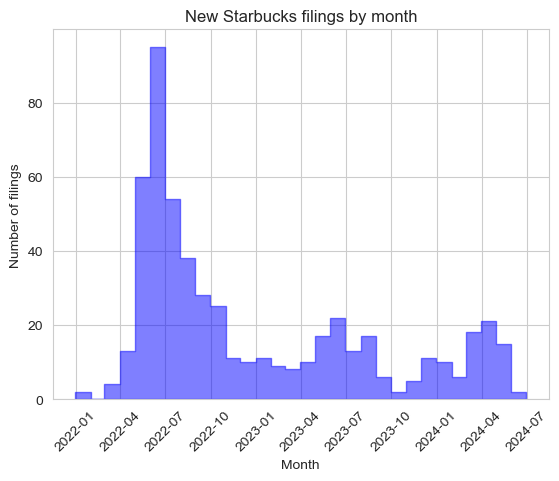

In [38]:
plt.fill_between(filings_per_month.index,filings_per_month, color = 'blue', alpha=0.5, step='pre')
plt.ylabel("Number of filings")
plt.xticks(rotation = 45)
plt.xlabel("Month")
plt.ylim(bottom = 0)
plt.title("New Starbucks filings by month")
plt.show()

### UE

In [24]:
ue_elections = single_elections[single_elections['Union'] == "UE"]

In [25]:
ue_elections.index = ue_elections['Date Closed']

In [26]:
ue_elections.groupby(by = ue_elections['Date Closed'].dt.year)['Outcome'].value_counts()

Date Closed  Outcome
2007         Loss       1
             Win        1
2008         Win        7
             Loss       3
2010         Win        3
             Loss       1
2011         Win        1
2012         Loss       2
             Win        2
2013         Win        1
2014         Win        1
             Loss       1
2015         Win        5
2016         Win        5
2017         Win        4
             Loss       2
2018         Win        1
2019         Win        2
2020         Win        1
2021         Win        2
             Loss       1
2022         Win        2
2023         Win        6
2024         Win        1
Name: count, dtype: int64

In [27]:
ue_elections['Number Unionized'] = ue_elections['No of Eligible Voters']*ue_elections['Outcome'].apply(lambda x: 1 if x == "Win" else 0)

/var/folders/pz/n_v30dyj09bfnyhk_h1dnfnm0000gn/T/ipykernel_7990/3444951292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ue_elections['Number Unionized'] = ue_elections['No of Eligible Voters']*ue_elections['Outcome'].apply(lambda x: 1 if x == "Win" else 0)


In [28]:
number_unionized_by_month = ue_elections['Number Unionized'].resample("M").sum()

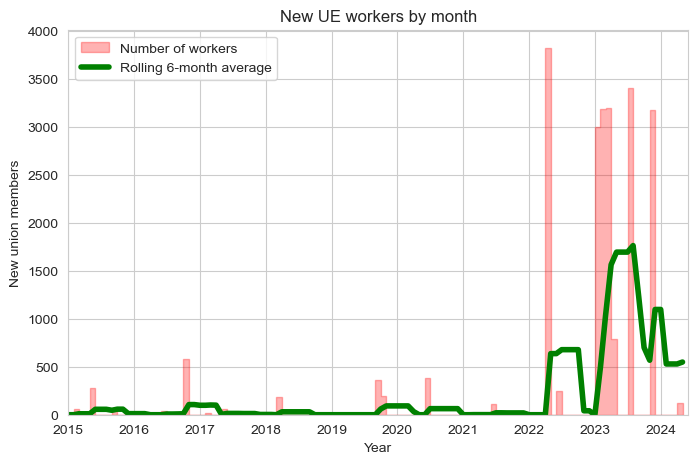

In [29]:
rolling_window = 6
rolling_average_number_by_month = number_unionized_by_month.loc["2014-07":"2024-04"].rolling(rolling_window).mean()
plt.figure(figsize = (8, 5))
plt.fill_between(number_unionized_by_month.loc["2014-12-31":"2024-04"].index, number_unionized_by_month.loc["2014-12-31":"2024-04"],  
                 color = 'red',
                 alpha = 0.3,
                 step='pre',
                label = f"Number of workers")
plt.plot(rolling_average_number_by_month.index, rolling_average_number_by_month, 
                 color = 'green',
                 linewidth = 4,
                label = f"Rolling {rolling_window}-month average")
number_unionized_by_month.loc["2015":"2024-04"]
plt.xlabel("Year")
plt.ylabel("New union members")
plt.ylim(bottom = 0)
plt.xlim(left = pd.to_datetime("2015-01-01"),right = pd.to_datetime("2024-06"))
plt.title(f"New UE workers by month")
plt.legend(loc = 'upper left')
plt.show()

In [46]:
ue_view = ue_elections[['Region', 'Case Number', 'Case Name', 'Status', 'Date Filed','Percent Votes Yes', 'Outcome', 'No of Eligible Voters',
       'Date Closed', 'Reason Closed', 'City', 'States & Territories','Turnout',
       'Number Unionized', 'Duration']].sort_index()
ue_view.index = list(range(len(ue_view)))
ue_view.style.apply(lambda x: 15*['background-color:#AAFFAA' if x['Outcome'] == "Win" else 'background-color:white'], axis = 1)

,Region,Case Number,Case Name,Status,Date Filed,Percent Votes Yes,Outcome,No of Eligible Voters,Date Closed,Reason Closed,City,States & Territories,Turnout,Number Unionized,Duration
0,"Region 22, Newark, New Jersey",22-RC-012310,"Hishi Plastic, Inc.",Closed,2003-02-10 00:00:00,0.846000,Win,42.000000,2007-03-27 00:00:00,Certific. of Representative,Lincoln Park,NJ,0.904762,42.000000,1506.000000
1,"Region 01, Boston, Massachusetts",01-RC-022095,Committee On Temporary Shelter (Cots),Closed,2007-03-02 00:00:00,0.447000,Loss,39.000000,2007-04-12 00:00:00,Certification of Results,Burlington,VT,0.948718,0.000000,41.000000
2,"Region 01, Boston, Massachusetts",01-RC-022173,"Northrop Grumman Technical Services, Inc.",Closed,2007-12-21 00:00:00,0.588000,Win,107.000000,2008-02-11 00:00:00,Certific. of Representative,Saint Albans,VT,0.906542,107.000000,52.000000
3,"Region 01, Boston, Massachusetts",01-RC-022172,Choctaw Archiving Enterprises,Closed,2007-12-21 00:00:00,0.622000,Win,87.000000,2008-02-11 00:00:00,Certific. of Representative,Saint Albans,VT,0.942529,87.000000,52.000000
4,"Region 01, Boston, Massachusetts",01-RC-022174,Federal Working Group,Closed,2007-12-21 00:00:00,0.400000,Loss,20.000000,2008-02-11 00:00:00,Certification of Results,Saint Albans,VT,1.000000,0.000000,52.000000
5,"Region 21, Los Angeles, California",21-RC-021007,Studley Professional Staffing,Closed,2008-01-23 00:00:00,0.742000,Win,34.000000,2008-03-05 00:00:00,Certific. of Representative,Laguna Niguel,CA,0.911765,34.000000,42.000000
6,"Region 21, Los Angeles, California",21-RC-021006,Choctaw Archiving Enterprises,Closed,2008-01-23 00:00:00,0.919000,Win,151.000000,2008-03-06 00:00:00,Certific. of Representative,Laguna Niguel,CA,0.894040,151.000000,43.000000
7,"Region 21, Los Angeles, California",21-RC-021008,"Northrop Grumman Technical Services, Inc., A Subsidiary Of Northrop Grumman Systems Corp.",Closed,2008-01-24 00:00:00,0.724000,Win,154.000000,2008-03-06 00:00:00,Certific. of Representative,Laguna Niguel,CA,0.941558,154.000000,42.000000
8,"Region 21, Los Angeles, California",21-RC-021009,"Stanley Associates, Inc.",Closed,2008-01-24 00:00:00,0.575000,Win,185.000000,2008-03-14 00:00:00,Certific. of Representative,Laguna Niguel,CA,0.962162,185.000000,50.000000
9,"Region 01, Boston, Massachusetts",01-RC-022171,"Stanley Associates, Inc.",Closed,2007-12-21 00:00:00,0.373000,Loss,166.000000,2008-03-20 00:00:00,Certification of Results,Saint Albans,VT,0.843373,0.000000,90.000000


In [40]:
ue_view

,Region,Case Number,Case Name,Status,Date Filed,Percent Votes Yes,Outcome,Date Closed,Reason Closed,City,States & Territories,Turnout,Number Unionized,Duration
Date Closed,,,,,,,,,,,,,,
2008-06-04,"Region 13, Chicago, Illinois",13-RC-021738,Ferro Phanstiehl,Closed,2008-04-11,0.676,Win,2008-06-04,Certific. of Representative,Waukegan,IL,1.000,37.000,54.000
2008-04-01,"Region 21, Los Angeles, California",21-RC-021015,"Altron, Inc.",Closed,2008-02-08,0.414,Loss,2008-04-01,Certification of Results,La Grange,CA,0.935,0.000,53.000
2008-03-14,"Region 21, Los Angeles, California",21-RC-021009,"Stanley Associates, Inc.",Closed,2008-01-24,0.575,Win,2008-03-14,Certific. of Representative,Laguna Niguel,CA,0.962,185.000,50.000
2008-03-20,"Region 01, Boston, Massachusetts",01-RC-022171,"Stanley Associates, Inc.",Closed,2007-12-21,0.373,Loss,2008-03-20,Certification of Results,Saint Albans,VT,0.843,0.000,90.000
2008-03-06,"Region 21, Los Angeles, California",21-RC-021006,Choctaw Archiving Enterprises,Closed,2008-01-23,0.919,Win,2008-03-06,Certific. of Representative,Laguna Niguel,CA,0.894,151.000,43.000
2008-03-06,"Region 21, Los Angeles, California",21-RC-021008,"Northrop Grumman Technical Services, Inc., A S...",Closed,2008-01-24,0.724,Win,2008-03-06,Certific. of Representative,Laguna Niguel,CA,0.942,154.000,42.000
2008-03-05,"Region 21, Los Angeles, California",21-RC-021007,Studley Professional Staffing,Closed,2008-01-23,0.742,Win,2008-03-05,Certific. of Representative,Laguna Niguel,CA,0.912,34.000,42.000
2008-02-11,"Region 01, Boston, Massachusetts",01-RC-022173,"Northrop Grumman Technical Services, Inc.",Closed,2007-12-21,0.588,Win,2008-02-11,Certific. of Representative,Saint Albans,VT,0.907,107.000,52.000
2008-02-11,"Region 01, Boston, Massachusetts",01-RC-022172,Choctaw Archiving Enterprises,Closed,2007-12-21,0.622,Win,2008-02-11,Certific. of Representative,Saint Albans,VT,0.943,87.000,52.000
